# PID制御による倒立振子システムの制御

本稿では，PID制御による倒立振子システムの制御について記述します．倒立振子システムは，台車を制御して棒を直立させることを目的とするシステムであり，制御しない状態では棒が倒れてしまう不安定系です．このような系は，人間の二足歩行，衛星やロケットの姿勢制御系にも類似しており，安定して制御することが比較的難しいシステムです．


### 実行環境の準備

本稿では，Python 3.12を使用し，必要なパッケージをインストールします．
```
pip install jupyterlab, numpy, matplotlib, control, sympy
```

ここでは，制御系の設計・評価に有用な *Python Control Systems Library* を使用します．

簡単なダイナミクスモデルを定義し，アニメーションを表示するために [Gymnasium](https://gymnasium.farama.org/) を利用します．

```
pip install gymnasium[classic-control]
```

PID制御器の設計には，特性方程式を用いる代数的設計手法である**係数図法**を用います．係数図法に基づくゲイン計算には筆者が開発・公開しているPythonパッケージ CDM Toolbox を利用します．CDM Toolboxは，PyPiで公開されており，pip コマンドによりインストール可能です．

```
pip install cdmtb
```


#### 倒立振子のモデル化

倒立振子の運動モデルを示します．水平方向に移動する台車（質量：$M$）の上に棒（長さ：$2l$，質量：$m$）が取り付けられおり，取付軸周りで回転できるようになっています．台車を横方向に力 $f$ で押すことにより制御を行います．

<img src="images/cartpole.png" width="40%" title="図3 倒立振子の運動モデル" alt="図3 倒立振子の運動モデル\label{fig-cartpole}">

システムの状態を表す状態量を定義します．ここでは，棒の回転角を $\theta$，回転角速度を $\dot{\theta}$ とし，台車の水平方向位置を $s$，速度を $\dot{s}$とします．また，操作量 $u$ を，台車を横方向に押す力 $f$ とします．

運動方程式は，以下のように記述されます．ここでは，簡単のため，摩擦力は無視することにします．最初の式が台車全体を含む並進運動，二番目の式が棒の回転運動のダイナミクスを表わします．

\begin{align}
(M+m)\ddot{s}+ml\ddot{\theta}\cos\theta-ml\dot{\theta}^2\sin\theta &= f \\
\frac{4}{3}ml^2\ddot{\theta} - mlg\sin\theta &= -ml\ddot{s}\cos\theta
\end{align}

#### 倒立振子の線形ダイナミクスモデル

$\theta=0$ 周りで線形化を行うと，以下の状態方程式の$\mathbf{A}$，$\mathbf{B}$が導かれます．ここでは，$\sin\theta \approx \theta$，$\cos\theta=1$ および高次項を省略する近似を用いています．

\begin{equation}
\mathbf{A} = \left[\begin{matrix}
 0 & 1 & 0 & 0 \\
 0 & 0 & -\frac{mlg}{\Delta} & 0 \\
 0 & 0 & 0 & 1 \\
 0 & 0 & \frac{(M+m)g}{\Delta} & 0
\end{matrix}\right],\quad
\mathbf{B} = \left[\begin{matrix}
 0 \\ \frac{4l}{3\Delta} \\ 0 \\ -\frac{1}{\Delta}
\end{matrix}\right]
\end{equation}

ただし，$\Delta = \frac{4}{3}(M+m)l-ml$ としています．

出力方程式の$\mathbf{C}$，$\mathbf{D}$については，例えば，位置$s$を出力する場合は以下のようになります．

\begin{equation}
\mathbf{C} = \left[\begin{matrix}
 1 & 0 & 0 & 0 
\end{matrix}\right], \quad
\mathbf{D} = \left[\begin{matrix}
 0 
\end{matrix}\right]
\end{equation}

$\mathbf{C}$に$n$次の単位行列を指定すると，全ての状態量が出力される**全状態フィードバック**となります．

#### Jupyter Notebook での試行

では，早速 Jupyter Notebook上で試してみましょう．まず，使用するパッケージを読み込みます．

In [28]:
import numpy as np
from scipy import linalg
import control as ct
import matplotlib.pyplot as plt
from gymnasium.envs.classic_control import CartPoleEnv
from IPython.display import Image

倒立振子の状態空間モデルを定義してみましょう．Gymnasiumの`CartPoleEnv`クラスから物理パラメータ（台車・棒の質量など）を読み込みます．デフォルトでは全状態フィードバックですが，関数`CartPoleSystem`の第二引数に`1`を指定すると，台車の位置 $s$ および棒の角度 $\theta$ ，`2`を指定すると台車の位置 `s` が出力となります．

In [4]:
def CartPoleSystem(env, mmode=0):

    g = env.gravity
    lp = env.length
    m = env.masspole
    M = env.masscart

    det = (4.0/3)*(M+m)*lp-m*lp
    A = np.array([[0, 1, 0, 0],
                  [0, 0, -m*lp*g/det, 0],
                  [0, 0, 0, 1],
                  [0, 0, (M+m)*g/det, 0]])
    B = np.array([[0], [4/3*lp/det], [0], [-1/det]])

    if mmode == 0:  # full state feedback
        C, D = np.eye(4), np.zeros((4, 1))
    elif mmode == 1:  # cart position & pole angle
        C, D = np.array([[1, 0, 0, 0], [0, 0, 1, 0]]), np.zeros((2, 1))
    elif mmode == 2: # cart position
        C, D = np.array([[1, 0, 0, 0]]), np.zeros((1, 1))

    sys = ct.ss(A, B, C, D)
    return sys

`CartPoleEnv`クラスのインスタンスを生成し，台車の位置 `s` を出力とする状態空間モデルを作成します．

In [34]:
# env = CartPoleEnv(render_mode="human")
env = CartPoleEnv(render_mode="rgb_array")
ulim = env.force_mag
sys = CartPoleSystem(env, 2)  # state: cart position
sys

StateSpace(array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.71707317,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        , 15.77560976,  0.        ]]), array([[ 0.        ],
       [ 0.97560976],
       [ 0.        ],
       [-1.46341463]]), array([[1., 0., 0., 0.]]), array([[0.]]))

状態空間モデルの出力は以下の形式で表示されます．

$$
\left[
    \begin{matrix}
    \mathbf{A} & \mathbf{B} \\ \mathbf{C} & \mathbf{D}
    \end{matrix}
\right]
$$

数値的なごみを省略して整理すると，伝達関数$G(s)$は以下のようになります．極・ゼロ点ともに実部が正の不安定極（ゼロ点）を有することがわかります．
$$
G(s) = \frac{0.9756s^2-14.34}{s^4-15.78s^2} = \frac{0.9756(s-3.83)(s+3.83)}{s^2(s-3.97)(s+3.97)}
$$

### シミュレーションの準備

Gymnasium のモデルを利用することで，倒立振子の制御の様子をアニメーション表示で確認することができます．シミュレーションを行う`CartPoleSim`関数を定義します．第5引数にオブザーバのゲインを指定するとオブザーバによる状態量推定が行われ，フィードバック制御に使用されます．



In [35]:
import imageio.v2 as imageio

def CartPoleSim(env, sys, ulim, F, L=None, filename='cartpole.gif'):

    nstep = 400
    t = np.arange(0, nstep+1)*env.tau

    x = np.zeros((nstep+1, 4))
    u = np.zeros((nstep+1, 1))
    xs = np.zeros((nstep+1, 4))

    xh, _ = env.reset(seed=1)
    x[0, :] = xh
    frames = []

    for i in range(nstep):
        # controller
        u_ = -F@xs[i, :]
        u_ = np.clip(u_, -ulim, ulim)[0]
        u[i] = u_

        if L is not None:  # observer
            ys = sys.C@xh
            dx = sys.A@xs[i, :] + sys.B@u[i] + L@(ys-sys.C@xs[i, :])
            xs[i+1, :] = xs[i, :] + dx*env.tau
        else:
            xs[i+1, :] = xh

        # get force direction (action) and force magnitude (force_mag)
        action = 1 if u_ > 0 else 0
        env.force_mag = np.abs(u_)

        # record frame for animation
        if env.render_mode == "rgb_array":
            frames.append(env.render())     
        # apply action
        xh, reward, terminated, truncated, _ = env.step(action)

        if terminated or truncated:
            print(f'Terminated after {i+1} iterations.')
            break

        x[i+1, :] = xh

    if env.render_mode == "rgb_array":
        imageio.mimsave(filename, frames, duration=0.02)  # 50 fps (0.02 s)

    return t[:i], x[:i, :], u[:i, :], xs[:i, :]

次に状態量ベクトル$\mathbf{x}$や制御入力$u$の時間応答を確認するための関数`ShowResult`を定義します．

In [27]:
def ShowResult(t, x, u, xs=None):

    col_t = 'bmgr'
    lbl_t = ['$x$ [m]', '$\\dot{x}$ [m/s]',
             '$\\theta$ [rad]', '$\\dot\\theta$ [rad/s]']
    plt.figure()
    for k in range(4):
        plt.plot(t, x[:, k], col_t[k]+'-', label=lbl_t[k])
        if xs is not None:
            plt.plot(t, xs[:, k], col_t[k]+'--')

    plt.grid()
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('states')
    plt.show()

    plt.figure()
    plt.plot(t[:], u[:, :])
    plt.grid()
    plt.xlabel('time [s]')
    plt.ylabel('control input [N]')
    plt.show()
 

### PD制御器の設計

倒立振子を制御対象としてPD制御器を設計してみましょう．出力は，台車の位置$s$ および棒の角度$\theta$ とし，それぞれ，PD制御器を適用します．制御対象を表す多項式は，以下のように定義できます．$B_p$ が2出力のため，行列表現となります．

\begin{equation}
A_p(s) = s^4-15.78s^2, \, B_p(s) = \left[\begin{matrix}0.98s^2-14.34 \\ -1.46s^2\end{matrix}\right]
\end{equation}

PD制御器を定義します．2出力系であるため，$B_c(s)$ は行列表現となります．

\begin{equation}
A_c(s) = 1, \, B_c(s) = \left[\begin{matrix}k_1s+k_0 \\ k_3s+k_2\end{matrix}\right], \, B_a(s) = k_0
\end{equation}

図\ref{fig-pid-sys} に制御系全体のブロック図を示します．なお，$B_a(s)$はステップ応答の定常ゲインを1とする条件から，$k_0$ とします．

<img src="images/pid_sys.png" width="60%" title="図6 倒立振子のPD制御" alt="図6 倒立振子のPD制御\label{fig-pid-sys}">


### Pythonによる計算

それでは，倒立振子の制御対象を多項式で定義してみましょう．


In [15]:
s = ct.tf('s')
Ap = s**4-15.78*s**2
Bp = [0.9756*s**2-14.34, -1.463*s**2]

安定度指標および時定数を指定してPD制御器の設計と評価を行う関数`cdmDesign`を定義します．この関数内では，`g2c`関数により特定多項式の係数の目標値を計算し，連立方程式を解くことにより，フィードバックゲインを求めます．また，`cdia`関数により，係数図をプロットします．

In [16]:
from cdmtb import cdia, aref, g2c

def cdmDesign(Ap, Bp, gr, taur):
    nc = 0 # Ac
    mc = [1, 1] # Bc: PD for s, PD for theta
    
    P, Ac, Bc = g2c(Ap, Bp, nc, mc, gr, taur)
    [k1, k0], [k3, k2] = Bc[0].num[0][0], Bc[1].num[0][0]
    Ba = k0
    F = np.array([[k0, k1, k2, k3]])

    p, _ = np.linalg.eig(sys.A-sys.B@F)
    print(f"F={F}\n poles = {p}")

    opt_p = [Ac*Ap, Bc[0]*Bp[0], Bc[1]*Bp[1]]
    leg_opt_p = ['$A_cA_p$', '$B_cB_p|_s$', '$B_cB_p|_{\\theta}$']
    cdia(P, opt_p, leg_opt_p)

    return Ac, Bc, Ba, F, P

次に，安定度指標および時定数を指定して，設計を行います．ここでは，以下の値を指定します．

$$
\gamma_1 = 2.5, \gamma_2=\gamma_3 = 2, \tau = 1.3
$$

F=[[ -3.05202054  -3.96762671 -33.043985    -7.90370766]]
 poles = [-15.7500451 +0.j          -1.04306503+1.67640928j
  -1.04306503-1.67640928j  -1.42577243+0.j        ]


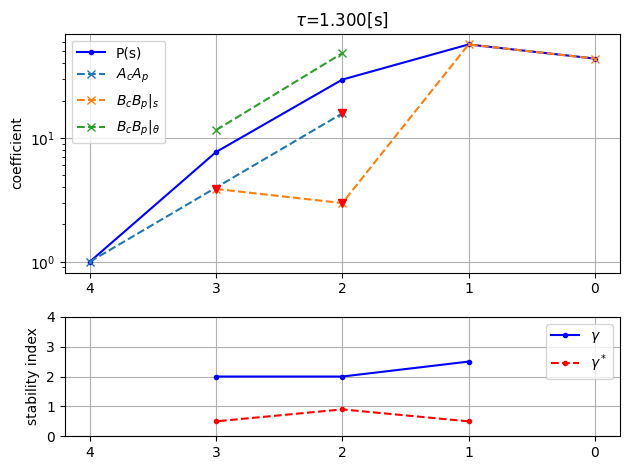

TransferFunction(array([ 1.        ,  7.69230769, 29.58579882, 56.89576695, 43.76597458]), array([1]))

In [17]:
gr = np.array([2.5, 2, 2])
taur = 1.3

Ac, Bc, Ba, F, P = cdmDesign(Ap, Bp, gr, taur)
P

フィードゲイン制御により配置された極（支配根）の実部が -1.93 と等しくなっていることがわかります．これは，係数図法の標準形の特徴で，応答が振動することなく，早い収束性が得られます．

係数図には，特性多項式の係数が実線でプロットされます．負の係数は絶対値が表示され，下三角の印がつきます．下図より目標とする安定度指標 $\gamma_i$ が実現されており，安定限界 $\gamma_i^*$ に対して十分なマージンを有していることが確認できます．

また，`cdia`関数にオプションとして追加の多項式を指定することにより，その係数をプロットすることができます．ここでは，特性多項式を構成する各フィードバック要素として， $A_cA_p$，$B_cB_p|_s$，$B_cB_p|_\theta$ の係数をプロットしています．

次に，シミュレーションにより応答を確認してみましょう．PD制御の計算には微分が必要ですが，$s$，$\theta$ の微分はそれぞれ $\dot{s}$，$\dot{\theta}$ であり，すでに状態量に含まれているため，全状態フィードバックで代用します．

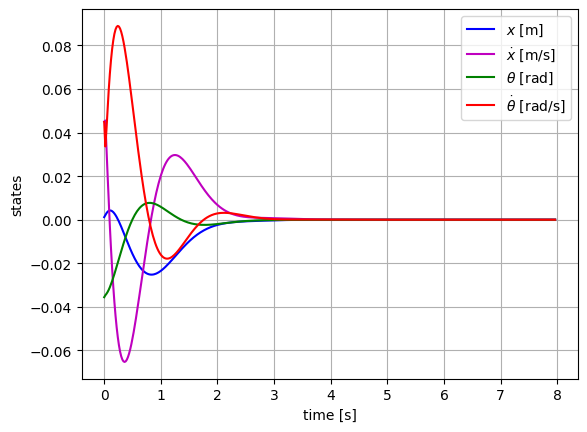

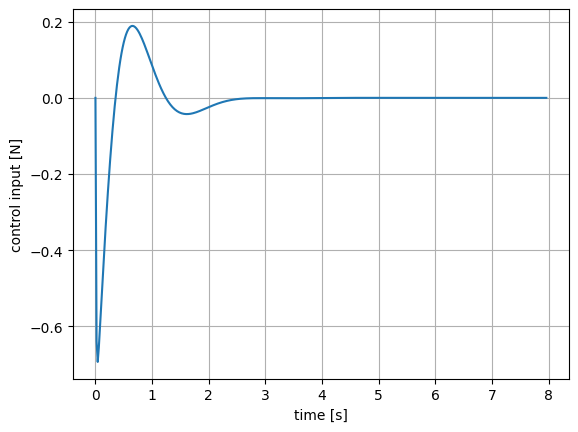

In [36]:
sys = CartPoleSystem(env)  # full state feedback
t, x, u, _ = CartPoleSim(env, sys, ulim, F, filename='cartpole.gif')
ShowResult(t, x, u)

# env.close()

アニメーションを表示します．

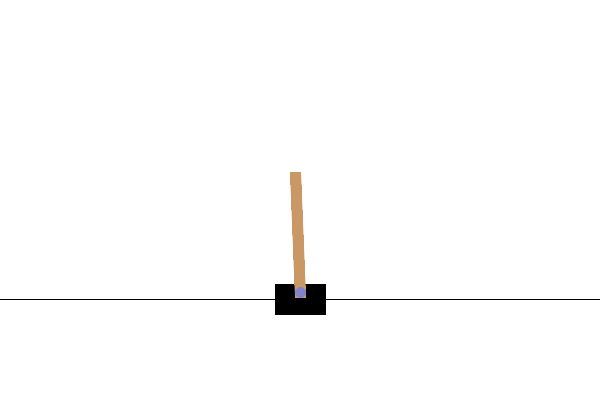

In [37]:
Image('cartpole.gif')

3秒程度で収束しており，収束性が良いことがわかります．

次に制御系のロバスト性を検証するために，システムの特性を変えてみましょう．倒立振子システムの棒の長さは短いほど制御が難しくなります．ここでは，棒の長さを半分にしてみます．制御系のゲインは，元の棒の長さに基づき設計したものをそのまま用います．

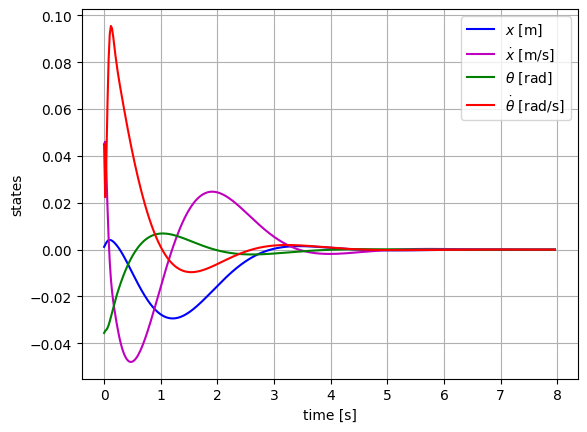

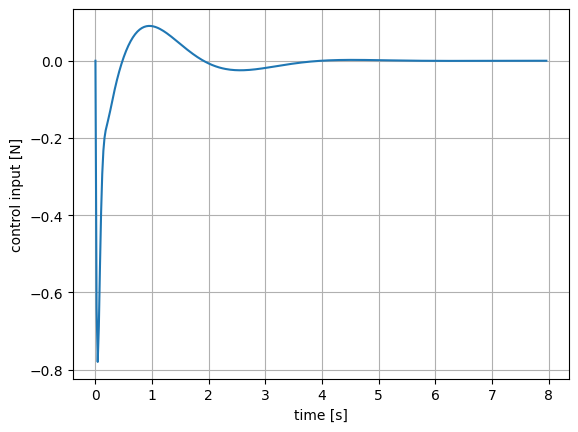

In [32]:
env2 = CartPoleEnv(render_mode="rgb_array")
env2.length *= 0.5  # shorten the pole
sys = CartPoleSystem(env2)  # full state feedback
t, x, u, _ = CartPoleSim(env2, sys, ulim, F, filename='cartpole_short.gif')
ShowResult(t, x, u)

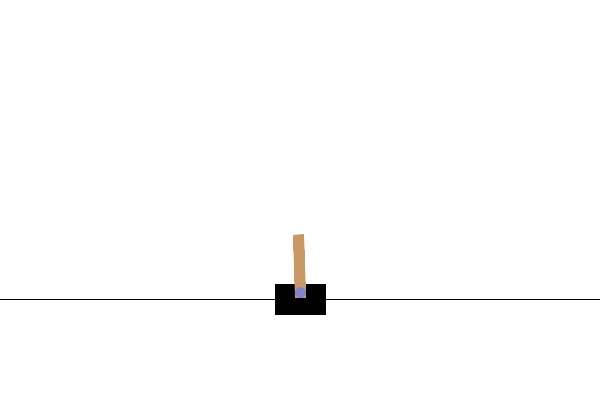

In [33]:
Image('cartpole_short.gif')

収束までの時間は約5秒と少し長くなりますが，システムの特性が変わっても，良好に制御できていることがわかります．

## 参考文献

- [1] Razvan V. Florian, “[Correct equations for the dynamics of the cart-pole system](https://coneural.org/florian/papers/05_cart_pole.pdf),”, 2005.
- [2] S. Fuller, B. Greiner, J. Moore, R. Murray, R. van Paassen and R. Yorke, "The Python Control Systems Library (python-control)," 2021 60th IEEE Conference on Decision and Control (CDC), Austin, TX, USA, 2021, pp. 4875-4881.
- [3] Karl Johan Åström, Richard Murray,“Feedback Systems: An Introduction for Scientists and Engineers, Second Edition,” Princeton University Press, 2021.
- [4] Shunji Manabe, Young Chol Kim, “Coefficient Diagram Method for Control System Design,”, Springer, 2021.
- [5] 真鍋, “[係数図法 制御系設計の理論と応用](http://www.cityfujisawa.ne.jp/~manabes/pdfJapanese/CH02mainJ.pdf),”, 2009
- [6] 足立, 丸田, “[カルマンフィルタの基礎](https://www.tdupress.jp/book/b349390.html),” 東京電機大学出版局 , 2012.